In [1]:
import numpy
import os
import re
from tfidf import read_markdown_files
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
corpus = read_markdown_files("..")

In [3]:
print(f'read {len(corpus)} documents')
for filename in list(corpus.keys())[:5]:
    print(f'{filename}')
print('...')

read 165 documents
../distributed-systems/dynamo-db.md
../distributed-systems/disconnected-operation.md
../distributed-systems/bigtable.md
../distributed-systems/RPC.md
../distributed-systems/paxos-intro.md
...


In [4]:
def normalize_text_to_words(text):
    words = re.findall(r'\w+', text.lower())
    return words

class Dataset:
  
  def __init__(self, corpus, vocab_size=10000):
    self.corpus = {
      p: self.normalize(t) for p, t in corpus.items()
    }
    self.path_list = list(self.corpus.keys())
    self._path_to_idx = {path: i for i, path in enumerate(self.path_list)}
    self.vocab = set()
    self.word_to_idx = {}
    self.idx_to_word = {}
    self.vocab_size = vocab_size
    self._build_vocab()
    self._remove_unk()

  def normalize(self, text):
    return normalize_text_to_words(text)
  
  def _build_vocab(self):
    word_counts = Counter()
    for path, words in self.corpus.items():
      word_counts.update(words)
      
    # remove words that are shorter than 3 characters
    for word in list(word_counts.keys()):
      if len(word) < 3:
        del word_counts[word]
        
    top_k_words = [word for word, _ in word_counts.most_common(self.vocab_size)]
    self.vocab = set(top_k_words)
    self.word_to_idx = {word: i for i, word in enumerate(self.vocab)}
    self.idx_to_word = {i: word for i, word in enumerate(self.vocab)}
    
  def _remove_unk(self):
    self.corpus = {
      p: [w for w in words if w in self.vocab] for p, words in self.corpus.items()
    }


In [5]:
class PPMIMatrix:

    def __init__(self, dataset, context_size=20):
        self.dataset = dataset
        self._context_size = context_size
        self.V = len(dataset.vocab)
        self.X = numpy.zeros((self.V, self.V))
        
        self.N = 0
        # For each position, count valid context positions
        for words in dataset.corpus.values():
            for i in range(len(words)):
                # sure, you could optimize with math, but this isn't a bottleneck
                for j in range(i - context_size, i + context_size + 1):
                    if j >= 0 and j < len(words) and j != i:
                        self.N += 1
        self._build_cooccurrence_matrix()
        self._build_ppmi_matrix()

    def _build_cooccurrence_matrix(self):
        for path, words in self.dataset.corpus.items():
            for i, word in enumerate(words):
                word_idx = self.dataset.word_to_idx[word]
                for j in range(i - self._context_size, i + self._context_size + 1):
                    if j >= 0 and j < len(words) and j != i:
                        context_word = words[j]
                        context_word_idx = self.dataset.word_to_idx[context_word]
                        self.X[word_idx, context_word_idx] += 1

    def _build_ppmi_matrix(self):
        self.P = numpy.zeros((self.V, self.V))

        epsilon = 1e-10

        for i in range(self.V):
            for j in range(self.V):
                if self.X[i, j] > 0:
                    pmi = numpy.log2(
                        (self.X[i, j] * self.N)
                        / ((self.X[i].sum() + epsilon) * (self.X[:, j].sum() + epsilon))
                    )
                    self.P[i, j] = max(0, pmi)

    def get_ppmi(self, word1, word2):
        i = self.dataset.word_to_idx[word1]
        j = self.dataset.word_to_idx[word2]
        return self.P[i, j]

In [6]:
ds = Dataset(corpus, vocab_size=5000)
print(ds.vocab)
print(list(ds.corpus.values())[0])
print(f'vocabulary size: {len(ds.vocab)}')
print(f'word_to_idx: {list(ds.word_to_idx.items())[:5]}')

{'choice', 'managed', 'vpn', 'ranges', 'abort', 'instead', 'max_delay', 'writing', 'tokens', 'converts', 'configurable', 'kinds', 'exclusion', 'papers', 'converting', 'event_type', 'esp', 'resistor', 'val', 'finish', 'diagonalizable', 'degree', 'collapse', 'well', 'exp', 'refresh', 'r_2', 'closer', 'versa', 'study', 'allows', 'provide', '360859', 'sts', 'membership', 'reflect', 'google', 'doing', 'leader', 'stalls', 'odd', 'repair', 'show', 'named', 'directly', 'roommate', 'elsewhere', 'variant', 'triggers', 'schedules', 'tag', 'compromise', 'delayed', 'retransmission', 'omega', 'bins', 'dc_i', 'dividing', 'satisfy', 'spatial', 'battery', 'spades', 'java', 'integers', 'attempts', 'goes', 'pitfall', 'identifier', 'analyzing', 'creation', 'restrict', 'sources', 'special', 'spend', 'overhead', 'truth', 'cross', 'subproblems', 'consensus', 'friendly', 'garbage', 'namespace', 'document', 's_2', 'internet', 'become', 'mount', 'bigtable', 'incorrectly', 'hamming', 'digital', 'rts', 'clientinp

In [7]:
ppmim = PPMIMatrix(ds)

In [8]:
def show_pmim_heatmap(ppmim, words):
  plt.figure(figsize=(10, 10))
  plt.imshow(ppmim.P, cmap='hot', interpolation='nearest')
  plt.colorbar()
  plt.show()
  

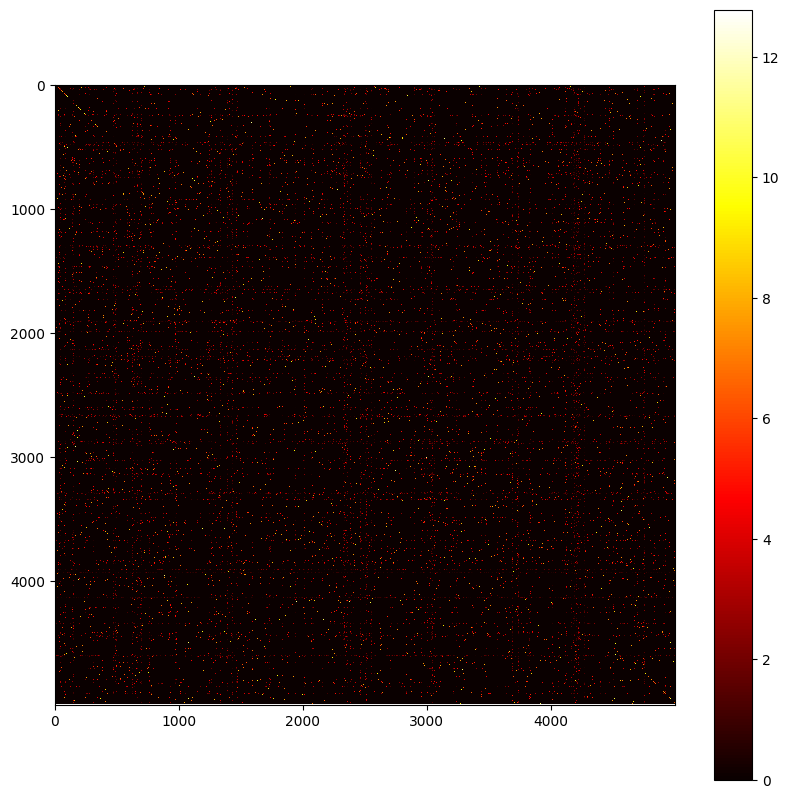

In [10]:
show_pmim_heatmap(ppmim, list(ds.vocab))